In [1]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.patches as mpatches
import os, sys
import numpy as np

from scipy import interpolate 

In [2]:
def cut_pt(time_step, full_len):
    for i in range(len(time_step)):
        if time_step[i] > full_len:
            return i

In [3]:
def data_interpolate(x, y, full_len):
    x_new = np.array(range(0, full_len, 4000))
    f_linear = interpolate.interp1d(x, y, fill_value="extrapolate", kind=1)
    y_new = f_linear(x_new)
    return y_new

In [4]:
def env_data_pack(log_path, env_name, algo_name_list, full_len):
    event_name = ["1", "2", "3"]
    Step_list = []
    Episode_Reward_list = []
    Episode_Length_list = []
    Episode_Win_num_list = []
    file_name = "results.csv"
    for algo_name in algo_name_list:        
        Time = []
        Episode_Reward = []
        Episode_Length = []
        Episode_Win_num = []
        for i in range(len(event_name)):
            path = log_path + "/" + env_name + '/' + algo_name + "/" + event_name[i] + "/" + file_name
            df = pd.read_csv(path)
            
            time_step = df["Time_step"]
            win_num = df["Average Win Num"]
            reward = df["Average reward"]
            epi_len = df["Average Episode Length"]
            
            cut_idx = cut_pt(time_step, full_len) 
            
            time_raw = np.array(time_step)[:cut_idx]
            win_num_raw = np.array(win_num)[:cut_idx]
            rwd_raw = np.array(reward)[:cut_idx]
            len_raw = np.array(epi_len)[:cut_idx]
            Time.append(time_raw)
            Episode_Reward.append(data_interpolate(time_raw, rwd_raw, full_len))
            Episode_Length.append(data_interpolate(time_raw, len_raw, full_len))
            Episode_Win_num.append(data_interpolate(time_raw, win_num_raw, full_len))
        
        Step_list.append(Time)
        Episode_Reward_list.append(Episode_Reward)
        Episode_Length_list.append(Episode_Length)
        Episode_Win_num_list.append(Episode_Win_num)
    return Step_list, Episode_Reward_list, Episode_Length_list, Episode_Win_num_list

In [5]:
def smooth(data, smooth=1):
    if smooth > 1:
        """
        smooth data with moving window average.
        that is,
            smoothed_y[t] = average(y[t-k], y[t-k+1], ..., y[t+k-1], y[t+k])
        where the "smooth" param is width of that window (2k+1)
        """
        smooth_data = []
        y = np.ones(smooth)
        for datum in data:
            x = np.asarray(datum)
            z = np.ones(len(x))
            smoothed_x = np.convolve(x,y,'same') / np.convolve(z,y,'same')
            smooth_data.append(smoothed_x)
            
    return smooth_data

In [6]:
def plot_vanilla(env_name, data_list, algo_name_list, full_len, feature, colors):
    sns.set_style("whitegrid", {'axes.grid' : True,
                                'axes.edgecolor':'black'
                                })
    
    fig = plt.figure(figsize = (15, 10))
    plt.clf()
    ax = fig.gca()

    color_patch = []
    
    labels = algo_name_list
    
    if feature == "reward":
        data_label = 'Episode Reward'
    else:
        data_label = 'Episode Length'
        
    for color, label, data in zip(colors, labels, data_list):
        num_curve = len(data)
        time = []
        data_new = []
        smooth_data = smooth(data, 20)
        df = []
        
        for i in range(num_curve):
            d = {'Training Episodes': range(0, full_len, 4000), data_label: smooth_data[i] / 5}
            df_temp = pd.DataFrame(data=d)
            df.append(df_temp)
        df = pd.concat(df)
        sns.lineplot(data=df, x='Training Episodes', y=data_label, color=color, linewidth=5)
        color_patch.append(mpatches.Patch(color=color, label=label))
    
    plt.xlim([0, full_len])
    plt.xlabel('Time Steps', fontsize=40)

    
    if feature == "reward":
        plt.ylabel('Episodic Reward', fontsize=40)
    else:
        plt.ylabel('Episode Length', fontsize=40)
        
    lgd=plt.legend(
        frameon=True, fancybox=True, \
        prop={'weight':'bold', 'size':30}, handles=color_patch, loc="best")
    
        
    ax = plt.gca()
    
    ax.xaxis.get_offset_text().set(size=30)
    ax.yaxis.get_offset_text().set(size=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    
    sns.despine()
    plt.grid(visible=True, linewidth=3)
    plt.tight_layout()
    
    plt.savefig(env_name + ".jpg")
    plt.show()

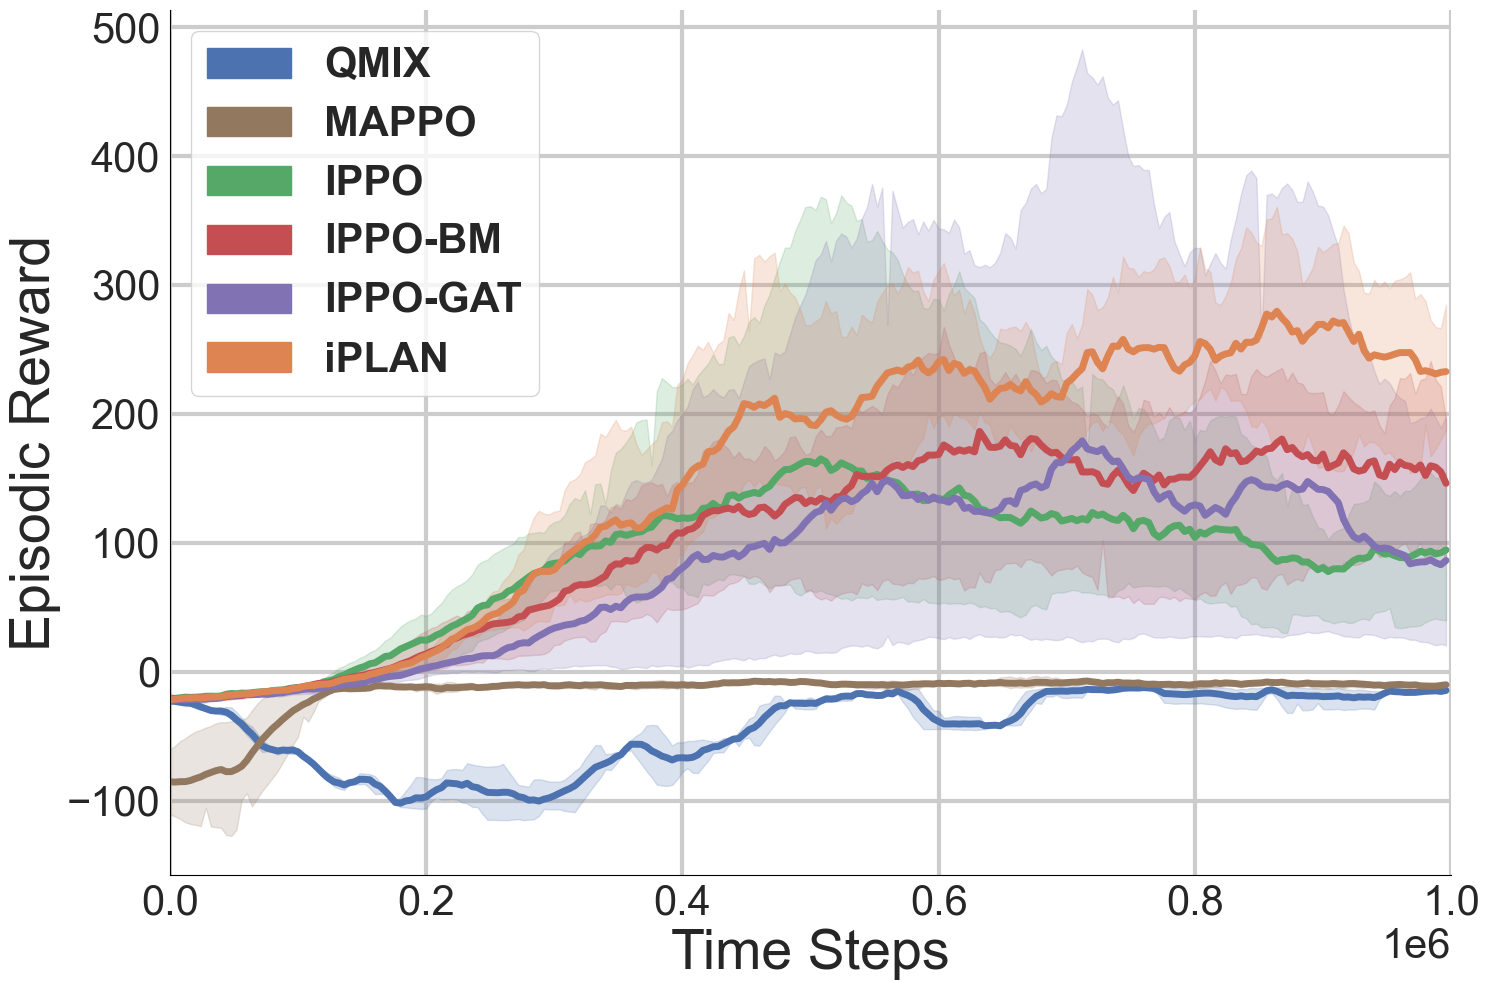

In [7]:
log_path = "D:/Nova_Highway/Results/Test"
env_name = "MPE_E_new"
full_len = 1000000
algo_name_list = ["QMIX", "MAPPO", "IPPO", "IPPO-BM", 
                  "IPPO-GAT", "iPLAN"]

color_palette = sns.color_palette("deep")
colors = [color_palette[0], color_palette[5], color_palette[2], color_palette[3], 
          color_palette[4], color_palette[1]]
    
Step_list, Episode_Reward_list1, Episode_Length_list, Episode_Win_num_list = env_data_pack(log_path, env_name, algo_name_list, full_len)
plot_vanilla(env_name, Episode_Reward_list1, algo_name_list, full_len, "reward", colors)

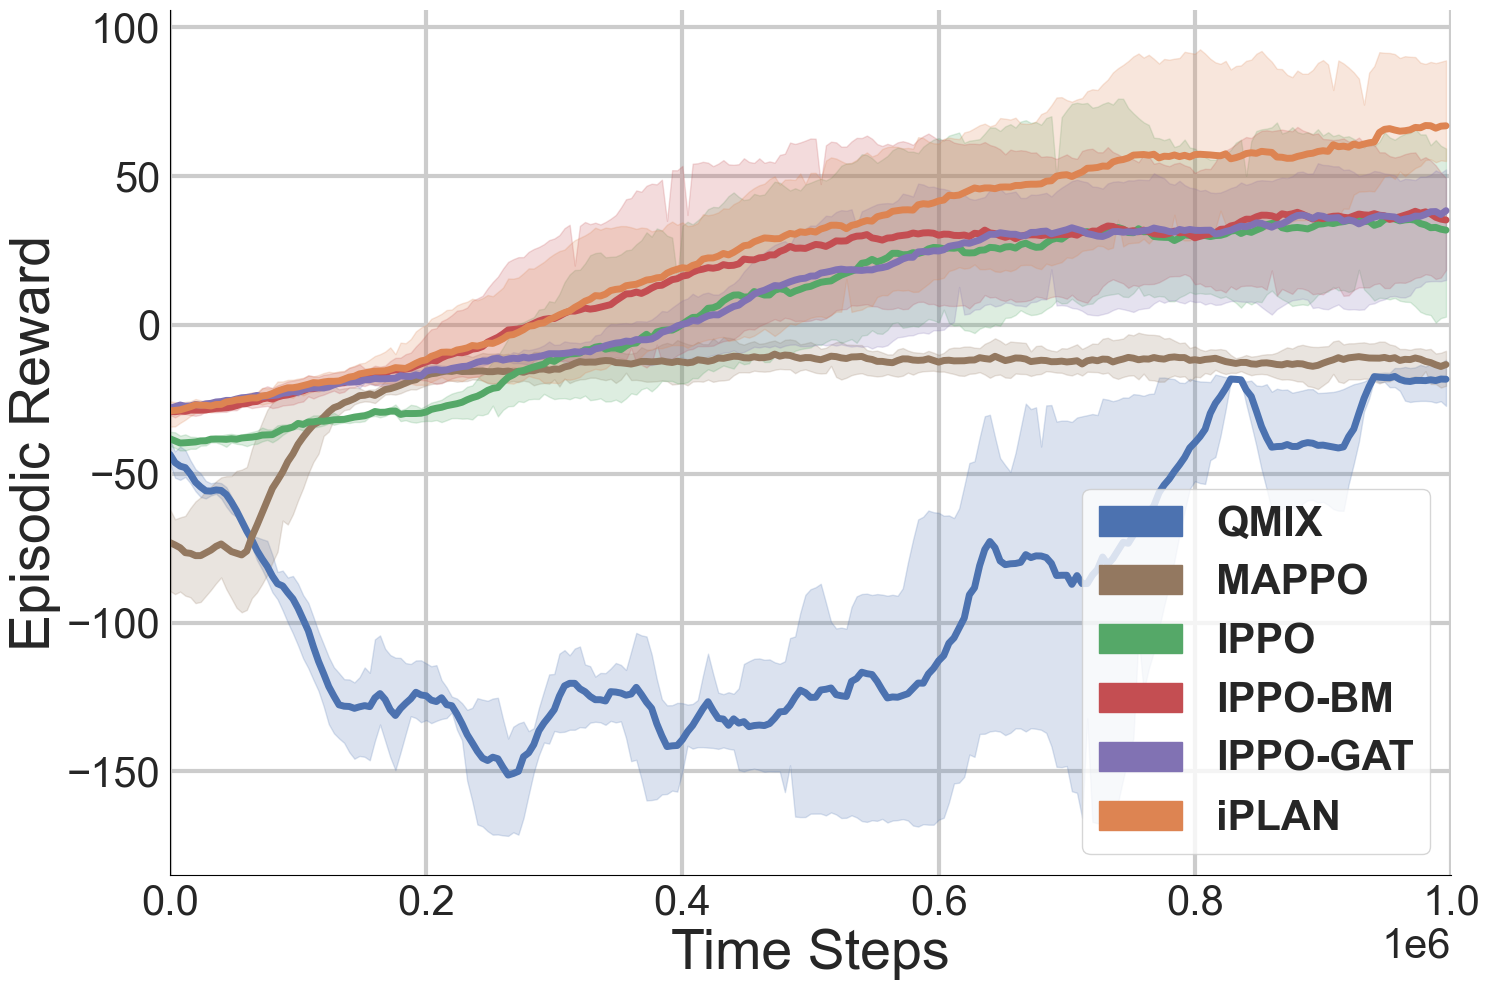

In [8]:
log_path = "D:/Nova_Highway/Results/Test"
env_name = "MPE_H_new"
full_len = 1000000
algo_name_list = ["QMIX", "MAPPO", "IPPO", "IPPO-BM", 
                  "IPPO-GAT", "iPLAN"]

color_palette = sns.color_palette("deep")
colors = [color_palette[0], color_palette[5], color_palette[2], color_palette[3], 
          color_palette[4], color_palette[1]]
    
Step_list, Episode_Reward_list2, Episode_Length_list, Episode_Win_num_list = env_data_pack(log_path, env_name, algo_name_list, full_len)
plot_vanilla(env_name, Episode_Reward_list2, algo_name_list, full_len, "reward", colors)